# Fast Image Preprocessing Implementation

I do not find a solution that can get the same result in a shorter time. So the conclusion is we need to do trade-off between implementation time and defference in embedding vectors.

I will present each method below.

Here are rules that we compare the preprocessing time:

> 1. The image is loaded as __PIL.Image__
> 2. The processed image is a __torch.tensor__
> 3. The processing time should take any necessary __type conversion__ into account
> 4. The speed test is done on __M1 Mac__

### Testing Image

We use the image from the github clip repo to do the test.

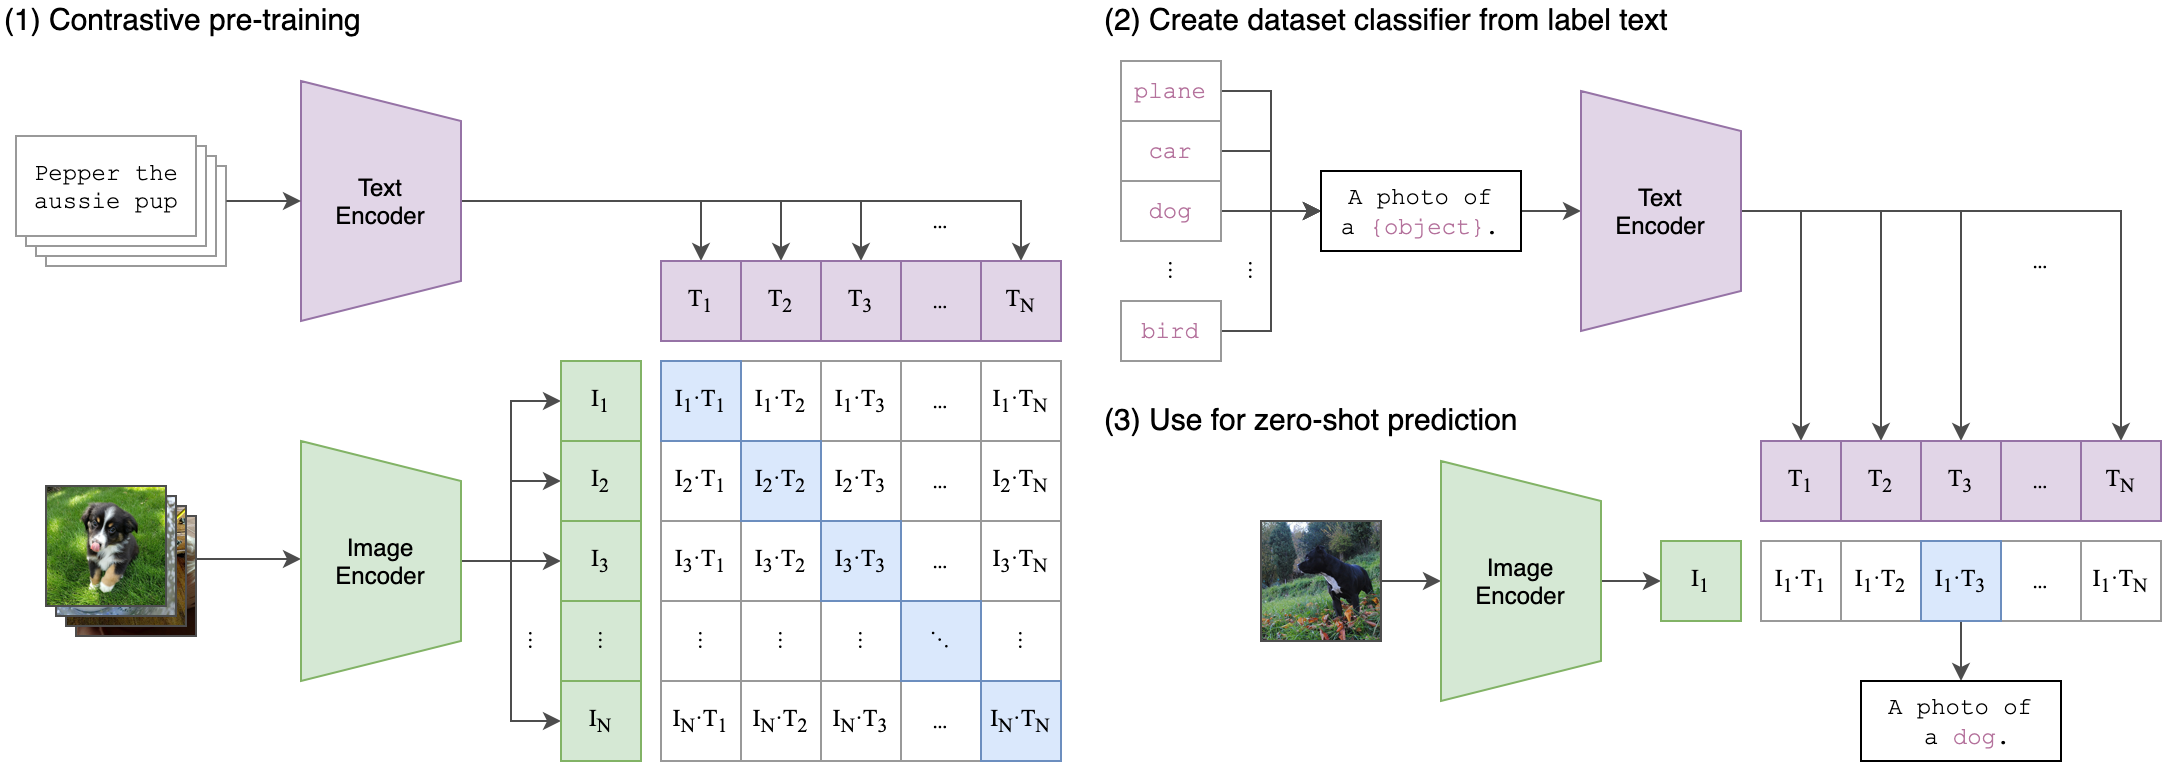

In [308]:
import clip
from torchvision import transforms
import numpy as np
import torch
from PIL import Image
import requests


from io import BytesIO

file = requests.get("https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png")

original_image = Image.open(BytesIO(file.content))

display(original_image)






In [15]:
original_image.size

(2162, 762)

In [16]:
original_image.getbands()

('R', 'G', 'B', 'A')

## Clip Preprocessing

In [17]:
model, clip_preprocess = clip.load("ViT-B/32", device = "cpu")

In [18]:
clip_processed = clip_preprocess(original_image)
clip_processed.shape

torch.Size([3, 224, 224])

In [294]:
%timeit clip_processed = clip_preprocess(original_image)

14.6 ms ± 27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Torchvision Transform (our implementation of clip preprocess)

In [20]:
from torchvision.transforms import Compose, Normalize, Resize, CenterCrop, ToTensor

def _convert_image_to_rgb(image):
    return image.convert("RGB")


torchvision_transform = Compose([
    #torchvision transform normally takes PIL Image as input
        Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        CenterCrop(224),
        _convert_image_to_rgb,
        transforms.ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])


In [21]:
torchvision_processed = torchvision_transform(original_image)

torchvision_processed.shape

torch.Size([3, 224, 224])

In [22]:
%timeit torchvision_processed = torchvision_transform(original_image)

14.7 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## OpenCV Based Transform

In [23]:
!pip install git+https://github.com/wanliAlex/augmennt#egg=augmennt

  Cloning https://github.com/wanliAlex/augmennt to /private/var/folders/ch/4txp5zp951j6xr15gq9_cw_r0000gn/T/pip-install-acreofiv/augmennt_f950609102624922afd355d127282bdf
  Running command git clone --filter=blob:none --quiet https://github.com/wanliAlex/augmennt /private/var/folders/ch/4txp5zp951j6xr15gq9_cw_r0000gn/T/pip-install-acreofiv/augmennt_f950609102624922afd355d127282bdf
  Resolved https://github.com/wanliAlex/augmennt to commit 88b53062182ff7e79b09fac79836e1a7aa94865c
  Preparing metadata (setup.py) ... done


In [24]:
from augmennt import transforms as at

def _convert_to_ndarray(image):
    return np.array(image)



at_transform = at.Compose([
    _convert_image_to_rgb, #this package can not convert the image mode, so we need to do the converstion first
    _convert_to_ndarray, #at transform takes ndarray as input
    at.Resize(224, interpolation = "BICUBIC"),
    at.CenterCrop(224),
    at.ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [25]:
at_processed = at_transform(original_image)

at_processed.shape

torch.Size([3, 224, 224])

In [26]:
%timeit at_processed = at_transform(original_image)

4.63 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Script Transfrom

In [302]:
# Note all the transforms are scriptable, so we need to
# break the whole transfrom into two parts.

script_part_one = Compose([
    _convert_image_to_rgb,
    transforms.ToTensor(),
])

script_part_two = torch.nn.Sequential(
    Resize(224, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    CenterCrop(224),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
)



In [303]:
script_processed = script_part_two(script_part_one(original_image))

script_processed.shape

torch.Size([3, 224, 224])

In [304]:
%timeit script_processed = script_part_two(script_part_one(original_image))

8.07 ms ± 70.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## RGB-Conversion Transform

In [30]:
rgb_transform = Compose([
    # We convert the image to rgb first before resize, centercrop, etc.
    _convert_image_to_rgb,
    Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    CenterCrop(224),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [31]:
rgb_processed = rgb_transform(original_image)

rgb_processed.shape

torch.Size([3, 224, 224])

In [32]:
%timeit rgb_processed = rgb_transform(original_image)

12.3 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## GreyScale-Conversion Transform

In [33]:
def _convert_image_to_grey(image):
    return image.convert("L")


grey_transform = Compose([
    # We convert the image to rgb first before resize, centercrop, etc.
    _convert_image_to_grey,
    Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    CenterCrop(224),
    _convert_image_to_rgb,
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [34]:
grey_processed = grey_transform(original_image)

grey_processed.shape

torch.Size([3, 224, 224])

In [35]:
%timeit grey_processed = grey_transform(original_image)

5.38 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Read from OpenCV

In [52]:
import cv2
#Let's read the image, Note that the image is in BGRa
cv_image = cv2.imread("CLIP.png", cv2.IMREAD_COLOR)

cv_image.shape

def _convert_bgr_to_rgb(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    



In [55]:
cv_transform = at.Compose([
    at.Resize(224, interpolation = "BICUBIC"),
    at.CenterCrop(224),
    _convert_bgr_to_rgb,
    at.ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

readcv_processed = cv_transform(cv_image)

readcv_processed.shape

torch.Size([3, 224, 224])

In [56]:
%timeit readcv_processed = cv_transform(cv_image)

991 µs ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Albumentation Implementation

# Now We Compare The Difference

We compare the difference in two fields:

> 1. __Processed Image__ in shape (3, 224, 224)
> 2. __Embedding vectors__ in shape (1, 512)

In [298]:
compare_dict = {"our_clip_transform" : torchvision_processed, 
                 "opencv" : at_processed, 
                "script": script_processed, 
                "rgb" : rgb_processed, 
                "grey" : grey_processed,
                "read_cv":readcv_processed}

In [299]:
def compare_diff(a, b):
    _mean = np.abs(np.array(a) - np.array(b)).mean()
    _sum = np.abs(np.array(a) - np.array(b)).sum()
    _shape = np.array(a).shape
    _size = np.array(a).size
    print(f"The total number of elements are {_size} with shape = {_shape}")
    print(f"The mean difference is {_mean}. The total difference is {_sum}")
    print("---" * 10)
    

In [300]:
for transform_name in compare_dict:
    print(f"The difference between model {transform_name} and the original clip:")
    compare_diff(clip_processed, compare_dict[transform_name])

print("We now compare the processed image:")

The difference between model our_clip_transform and the original clip:
The total number of elements are 150528 with shape = (3, 224, 224)
The mean difference is 0.0. The total difference is 0.0
------------------------------
The difference between model opencv and the original clip:
The total number of elements are 150528 with shape = (3, 224, 224)
The mean difference is 1.2206215858459473. The total difference is 183737.734375
------------------------------
The difference between model script and the original clip:
The total number of elements are 150528 with shape = (3, 224, 224)
The mean difference is 0.07803668081760406. The total difference is 11746.705078125
------------------------------
The difference between model rgb and the original clip:
The total number of elements are 150528 with shape = (3, 224, 224)
The mean difference is 0.031177524477243423. The total difference is 4693.09033203125
------------------------------
The difference between model grey and the original clip:

In [301]:
with torch.no_grad():
    clip_encode = model.encode_image(clip_processed.unsqueeze(0))


for transform_name in compare_dict:
    print(f"The difference between model {transform_name} and the original clip:")
    with torch.no_grad():
        compare_diff(clip_encode, model.encode_image(compare_dict[transform_name].unsqueeze(0)))

print("We now compare the embedding vectors:")

The difference between model our_clip_transform and the original clip:
The total number of elements are 512 with shape = (1, 512)
The mean difference is 0.0. The total difference is 0.0
------------------------------
The difference between model opencv and the original clip:
The total number of elements are 512 with shape = (1, 512)
The mean difference is 0.19011753797531128. The total difference is 97.34017944335938
------------------------------
The difference between model script and the original clip:
The total number of elements are 512 with shape = (1, 512)
The mean difference is 0.13140110671520233. The total difference is 67.2773666381836
------------------------------
The difference between model rgb and the original clip:
The total number of elements are 512 with shape = (1, 512)
The mean difference is 0.047554295510053635. The total difference is 24.34779930114746
------------------------------
The difference between model grey and the original clip:
The total number of elem

TRANSFORMS | TIME (ms) | PROCESSED DIFF (mean) | ENCODE DIFF (mean) 
--- | --- | --- | --- 
original_clip | 14.6 | 0.0 | 0.0 
our_clip_implementation | 14.7 | 0.0| 0.0 
opencv_based |4.67 | 1.22 | 0.19
script_based |8.07 | 0.037 | 0.0526
rgb_conversion | 12.1 | 0.031 | 0.0475
grey_conversion | 5.33 | 0.053 | 0.121
read_from_cv | 0.940 | 1.22 | 0.19

In [128]:
rgb_cv_image = _convert_bgr_to_rgb(cv_image)
rgb_cv_image.shape


(762, 2162, 3)

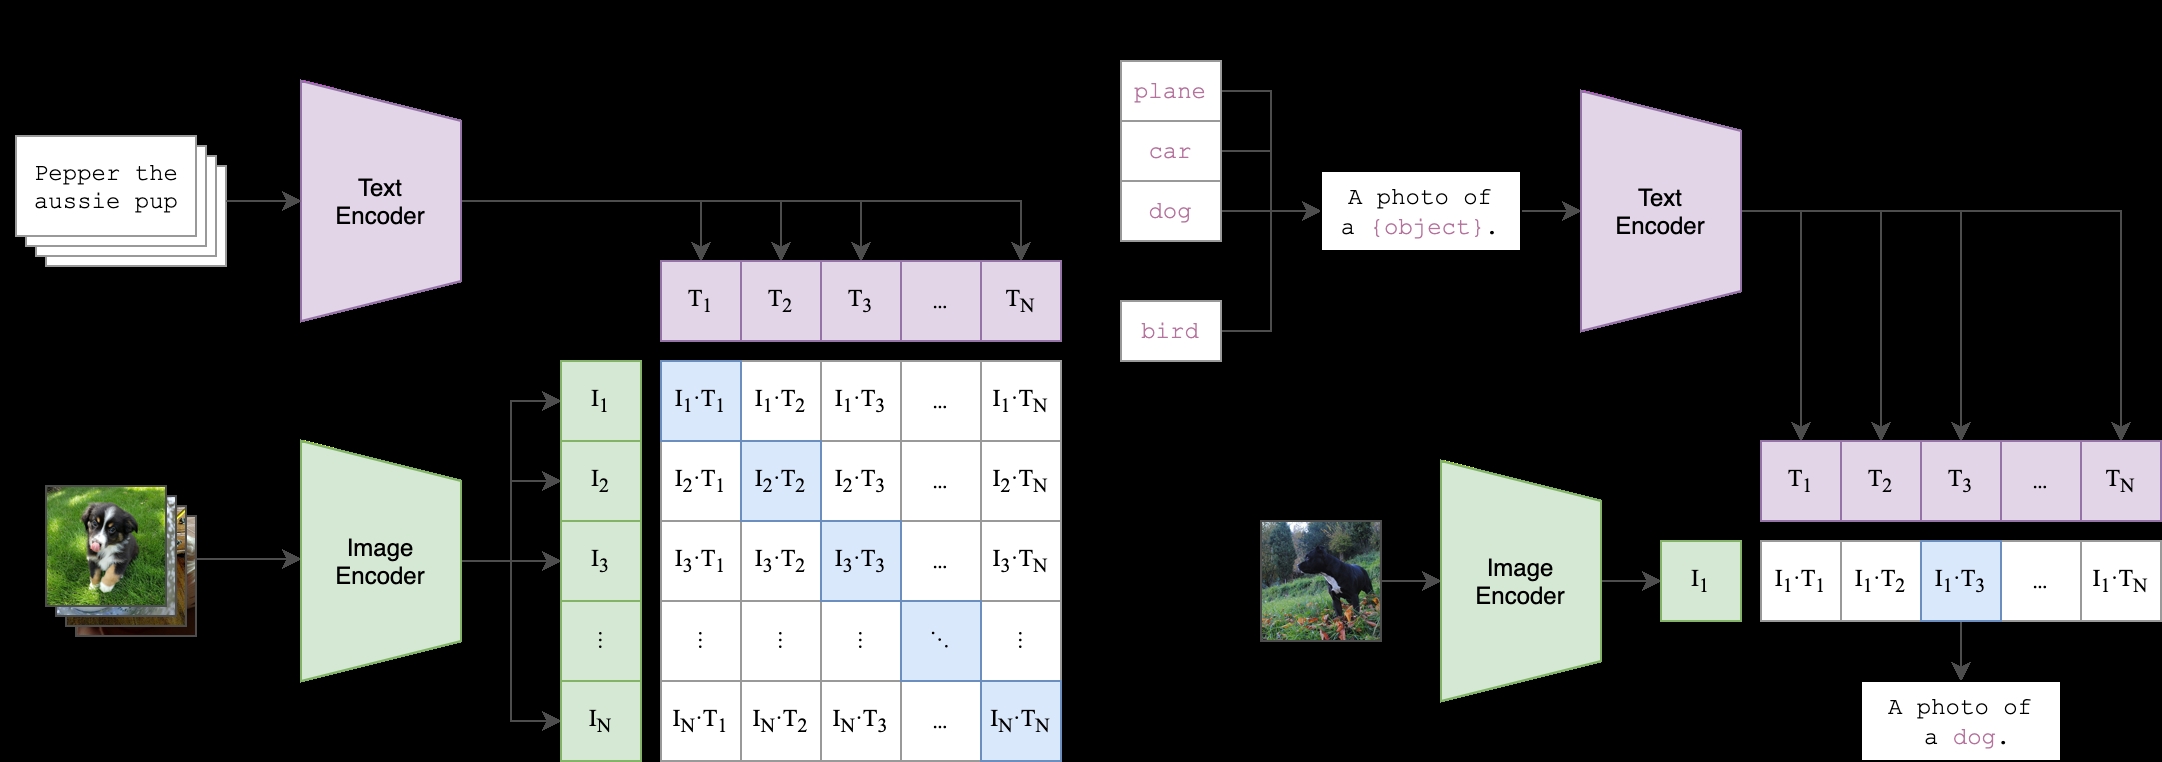

In [129]:
display(Image.fromarray(rgb_cv_image))

In [130]:
rgb_image = _convert_image_to_rgb(original_image)

np.array(rgb_image).shape

(762, 2162, 3)

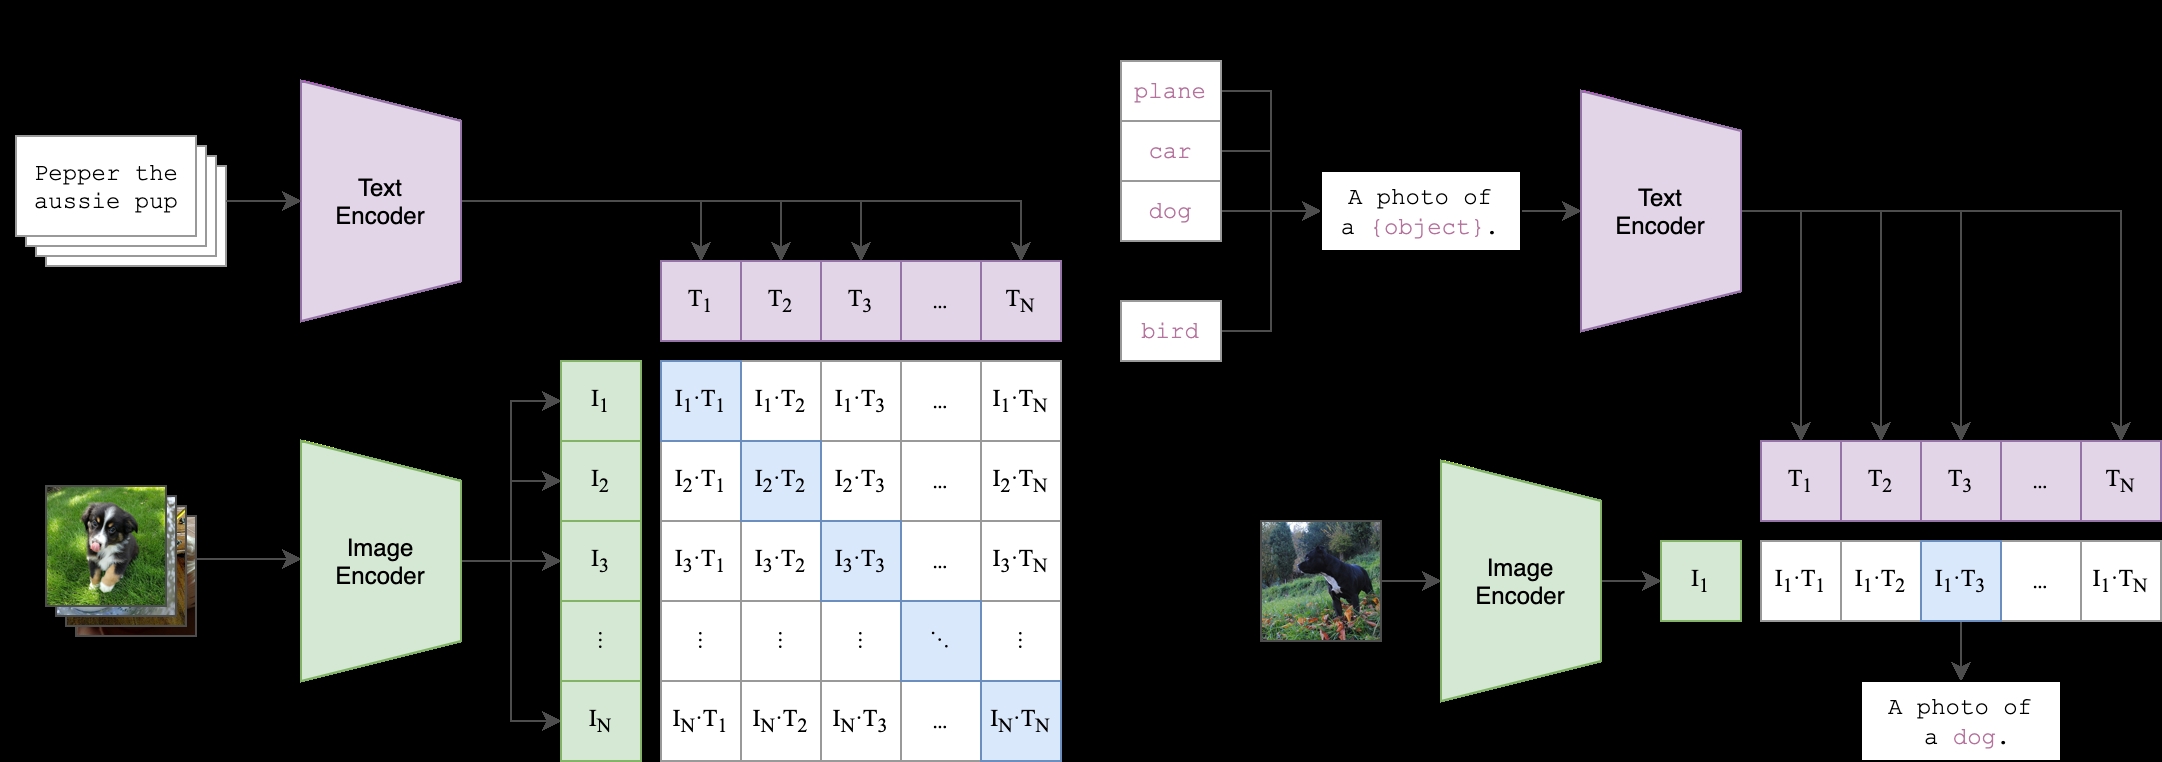

In [131]:
display(rgb_image)

In [132]:
(np.array(rgb_image) == rgb_cv_image).mean()

1.0

In [169]:
cv_resized = cv2.resize(rgb_cv_image, dsize = (635,224), interpolation = cv2.INTER_CUBIC)
cv_resized.shape

(224, 635, 3)

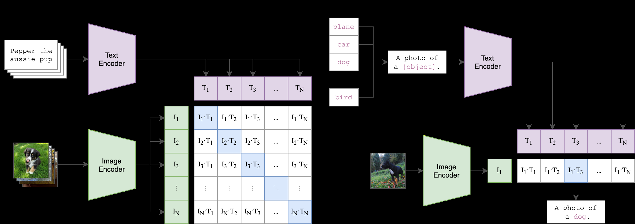

In [170]:
display(Image.fromarray(cv_resized))

In [171]:
pil_resize = rgb_image.resize(size = (635, 224), resample = Image.Resampling.BICUBIC)
np.array(pil_resize).shape


(224, 635, 3)

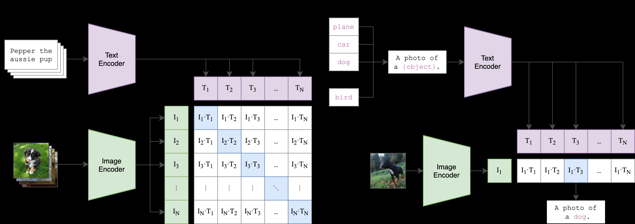

In [172]:
display(pil_resize)

In [173]:
compare_diff(pil_resize, cv_resized)

The total number of elements are 426720 with shape = (224, 635, 3)
The mean difference is 17.86525824896888. The total difference is 7623463
------------------------------


In [174]:
(np.array(pil_resize) == cv_resized).mean()

0.8431055493063367

In [265]:
import resize_right as rr
 
rr_resized = rr.resize(transforms.ToTensor()(rgb_cv_image), out_shape = (224,635), 
                       antialiasing=True, pad_mode='replicate').clip(0,1)

rr_resized.shape

torch.Size([3, 224, 635])

In [275]:
rr_image = (rr_resized.numpy() * 255).astype("uint8").transpose(1,2,0)
rr_image.shape



(224, 635, 3)

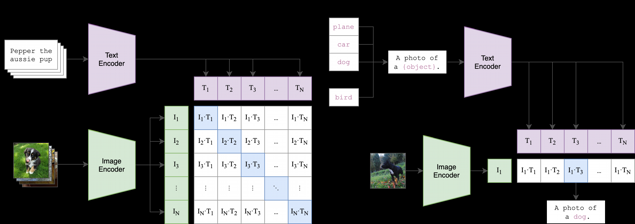

In [278]:
display(Image.fromarray((rr_image)))

In [307]:
(np.array(pil_resize) == rr_image).mean()

0.8497445631796026